# DL Project

In [43]:
import h5py
import torch 
import numpy as np
from PIL import Image
import io
import matplotlib.pyplot as plt
import random
from torch.utils.data import Dataset, DataLoader

from torch.autograd import Variable
from __future__ import print_function
%matplotlib inline
import argparse
import os
import random
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import sys, os


# Set random seed for reproducibility
# manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
# print("Random Seed: ", manualSeed)
# random.seed(manualSeed)
# torch.manual_seed(manualSeed)

In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
f = h5py.File('/content/drive/MyDrive/Colab Notebooks/Project/flowers.hdf5','r')
train_data = f['train']
keys = list(train_data)
list(f) 

['test', 'train', 'valid']

class_00041
class_00056
(1024,)
this flower has layered pink petals that has yellow stamen



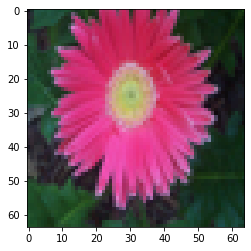

In [ ]:
# idx = random.randint(0,len(keys))
# idx2 = random.randint(0,len(keys))
# instance = f['train'][keys[idx]]
# inst2 = f['train'][keys[idx2]]
# print(instance['class'][()])
# print(inst2['class'][()])
# imgb = np.array(instance['img']).tobytes()
# print(np.array(instance['embeddings'],dtype=np.float).shape)
# print(instance['txt'][()])
# img = Image.open(io.BytesIO(imgb))
# # plt.subplot(2,1,1)
# # plt.imshow(img)
# # plt.subplot(2,1,2)
# # plt.imshow(Image.open(io.BytesIO(np.array(inst2['img']).tobytes())))
# img = img.resize((64,64),resample = 3)
# plt.imshow(img)
# plt.show()

In [46]:
class CustomDataset(Dataset):
    def __init__(self,file,splitType,transform=None):
        # splitType: train, test, val
        self.file = file
        self.transform = transform
        f = h5py.File(self.file,'r')
        self.dataset = f[splitType] ;# f.close()
        self.dkeys = list(self.dataset)
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self,index):
        inst_name = self.dkeys[index]
        inst = self.dataset[inst_name]

        rImg = (np.array(Image.open(io.BytesIO(np.array(inst['img']).tobytes())).convert("RGB").resize((64,64),resample = 3),dtype = np.float32) - 127.5)/127.5
        rImg = rImg.transpose(2,0,1)
        
        rEmbed = np.array(inst['embeddings'],dtype = float)
        randIndex = random.randint(0,len(self.dkeys)-1)
        while inst['class'][()] == self.dataset[self.dkeys[randIndex]]['class'][()]:
            randIndex = random.randint(0,len(self.dkeys)-1)    
        wImg = (np.array(Image.open(io.BytesIO(np.array(self.dataset[self.dkeys[randIndex]]['img']).tobytes())).convert("RGB").resize((64,64),resample = 3),dtype=np.float32) - 127.5)/127.5
        wImg = wImg.transpose(2,0,1)
        randIndex = random.randint(0,len(self.dkeys)-1)
        wEmbed = np.array(self.dataset[self.dkeys[randIndex]]['embeddings'],dtype = np.float32)


        txt = inst['txt'][()]
        special = u"\ufffd\ufffd"
        txt = txt.replace(special,' ')
        txt = str(np.array(txt).astype(str))

        dataPoint = {
                    'rImg': torch.FloatTensor(rImg),
                    'wImg': torch.FloatTensor(wImg),
                    'rEmbed': torch.FloatTensor(rEmbed),
                    'wEmbed': torch.FloatTensor(wEmbed),
                    'txt': txt 
                    }
        return dataPoint




In [47]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.img_size = 64
        self.nc = 3
        self.ndim = 100
        self.embed_dim = 1024
        self.projected_embed_dim = 128
        self.latent_dim = self.ndim + self.projected_embed_dim
        self.ngf = 64

        self.netProject = nn.Sequential(
            nn.Linear(in_features= self.embed_dim, out_features= self.projected_embed_dim),
            nn.BatchNorm1d(num_features = self.projected_embed_dim),
            nn.LeakyReLU(negative_slope=0.2,inplace = True)
        )

        self.netG = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( self.latent_dim, self.ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(self.ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(self.ngf * 8, self.ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( self.ngf * 4, self.ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( self.ngf * 2, self.ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( self.ngf, self.nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )
    def forward(self,embed ,noise):
        embed_projected = self.netProject(embed).unsqueeze(2).unsqueeze(3)
        latent = torch.cat([embed_projected,noise], 1)
        return self.netG(latent)
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        """ model_type: 0-> DCGAN , 1-> WGAN
        """

        self.img_size = 64
        self.nc = 3
        self.embed_dim = 1024
        self.projected_embed_dim = 128
        self.ndf = 64
        
        self.projector = nn.Sequential(
            nn.Linear(in_features=self.embed_dim, out_features=self.projected_embed_dim),
            nn.BatchNorm1d(num_features=self.projected_embed_dim),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )

        self.netD1 = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(self.nc, self.ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(self.ndf, self.ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(self.ndf * 2, self.ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(self.ndf * 4, self.ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ndf * 8),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.netD2 = nn.Sequential(
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(self.ndf * 8 + self.projected_embed_dim, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
       
          

    def forward(self, input,embed):
        x_int = self.netD1(input)
        x = self.projector(embed)
        rep_embed = x.repeat(4, 4, 1, 1).permute(2,  3, 0, 1)
        x = torch.cat([x_int, rep_embed], 1)
        x = self.netD2(x)
        return x.view(-1,1).squeeze(1),x_int  


In [48]:
# Number of workers for dataloader
workers = 1
# Batch size during training
# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64
# Number of channels in the training images. For color images this is 3
nc = 3
# Size of z latent vector (i.e. size of generator input)
nz = 100
# Size of feature maps in generator
ngf = 64
# Size of feature maps in discriminator
ndf = 64
# Number of training epochs
num_epochs = 50
# Learning rate for optimizers
lr = 0.0002
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1
l1_rate = 50
l2_rate = 100

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [7]:
model_type = 0 #0 -> dcgan , 1 -> wgan
pretrained = True

netG = Generator().to(device)
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

netG.apply(weights_init)

# Print the model
# print(netG)

netD = Discriminator().to(device)

if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

netD.apply(weights_init)

if pretrained:
    if (os.path.exists('/content/drive/MyDrive/Colab Notebooks/modelState/DCGAN_reg.pth') and model_type == 0):
        param_dict = torch.load('/content/drive/MyDrive/Colab Notebooks/modelState/DCGAN_reg.pth')
        print("Last Epoch: %d"%(param_dict['epoch']))
        netD.load_state_dict(param_dict['netD_state'])
        netG.load_state_dict(param_dict['netG_state'])
        epoch = param_dict['epoch']
        print('Parameters loaded')
    elif (os.path.exists('/content/drive/MyDrive/Colab Notebooks/modelState/WGAN.pth') and model_type == 1):
        param_dict = torch.load('/content/drive/MyDrive/Colab Notebooks/modelState/WGAN.pth')
        print("Last Epoch: %d"%(param_dict['epoch']))
        netD.load_state_dict(param_dict['netD_state'])
        netG.load_state_dict(param_dict['netG_state'])
        epoch = param_dict['epoch']
        print('Parameters loaded')

    
# Print the model
# print(netD)
batch_size = 128 if model_type == 0 else 64

Last Epoch: 0
Parameters loaded


In [49]:
dSet = CustomDataset(file = '/content/drive/MyDrive/Colab Notebooks/Project/flowers.hdf5',splitType='train')
trainloader = DataLoader(dSet,batch_size = batch_size,shuffle=True,num_workers = workers)
dSet_test = CustomDataset(file = '/content/drive/MyDrive/Colab Notebooks/Project/flowers.hdf5',splitType= 'test')
testloader = DataLoader(dSet_test,batch_size = 6 ,shuffle = True,num_workers = workers)



In [31]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = []

cls = False

print("Starting Training Loop...")
if model_type == 0:
    # Initialize BCELoss function
    criterion = nn.BCELoss()
    l2_loss = nn.MSELoss()
    l1_loss = nn.L1Loss()
    # Create batch of latent vectors that we will use to visualize
    #  the progression of the generator
    # fixed_noise = torch.randn(64, nz, 1, 1, device=device)
    # Setup Adam optimizers for both G and D
    optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
    optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=
                            (beta1, 0.999))
    # Establish convention for real and fake labels during training
    offset = 0.1
    real_label = 1.
    fake_label = 0.
    smooth_real_label = real_label - offset
    epoch = 0
    while epoch < num_epochs:
        epoch += 1
        for i, data in enumerate(trainloader, 0):
            # Training
            right_images = Variable(data['rImg'].float()).to(device)
            right_embeds  = Variable(data['rEmbed'].float()).to(device)
            wrong_images = Variable(data['wImg'].float()).to(device)
            real_labels  = torch.full((right_images.size(0),), smooth_real_label, dtype=torch.float, device=device)
            fake_labels = torch.full((right_images.size(0),), fake_label,dtype=torch.float,device= device)

            # (1) Discriminator
            netD.zero_grad()
            outputs, real_activations = netD(right_images,right_embeds)
            real_loss = criterion(outputs,real_labels)
            real_score = outputs

            noise = torch.randn((right_images.size(0),100),device = device)
            noise = noise.view(noise.size(0),100,1,1)
            fake_images = netG(right_embeds,noise)
            outputs, _ = netD(fake_images,right_embeds)
            fake_loss = criterion(outputs,fake_labels)
            fake_score = outputs

            netDLoss = real_loss + fake_loss
            if cls:
                outputs, _ = netD(wrong_images,right_embeds)
                wrong_loss = criterion(outputs,fake_labels)
                wrong_score = outputs
                netDLoss += wrong_loss 
            netDLoss.backward()
            optimizerD.step()

            # (2) Generator
            netG.zero_grad()
            noise = torch.randn((right_images.size(0),100),device = device)
            noise = noise.view(noise.size(0),100,1,1)
            fake_images = netG(right_embeds,noise)
            outputs, fake_activations = netD(fake_images,right_embeds)

            real_activations = torch.mean(real_activations, 0)
            fake_activations = torch.mean(fake_activations, 0)

            netGLoss = criterion(outputs, real_labels) + l1_rate*l1_loss(fake_images,right_images) + l2_rate*l2_loss(fake_activations,real_activations.detach())
            netGLoss.backward()
            optimizerG.step()

            if i%10 == 0:
                print("Epoch %d, Iter: %d, netDLoss: %f, netGLoss: %f, D(X): %f, D(G(X)): %f"%(
                    epoch, i, netDLoss.cpu().mean(), netGLoss.cpu().mean(), real_score.cpu().mean(), fake_score.cpu().mean()
                ))
            iters.append(i)
            G_losses.append(netGLoss.cpu().mean())
            D_losses.append(netDLoss.cpu().mean())

        if (epoch)%2 == 0:
            param_dict = param_dict = { "netD_state": netD.state_dict(),
                                        "netG_state": netG.state_dict(),
                                    "epoch" : epoch
                                    }
            torch.save(param_dict,'/content/drive/MyDrive/Colab Notebooks/modelState/DCGAN_reg.pth')
            print("model Saved...")
elif (model_type == 1):
    lr = 0.00005
    optimizerD = optim.Adam(netD.parameters(), lr=lr)
    optimizerG = optim.Adam(netG.parameters(), lr=lr)
    # Establish convention for real and fake labels during training
    offset = 0.1
    real_label = -1.
    fake_label = 1.
    smooth_real_label = real_label - offset
    d_step = 5
    g_step = 1
    c = 0.01    
    for e in range(num_epochs):
        for iteration,data in enumerate(trainloader):
            # Training
            right_images = Variable(data['rImg'].float()).to(device)
            right_embeds  = Variable(data['rEmbed'].float()).to(device)
            wrong_images = Variable(data['wImg'].float()).to(device)
            for t in range(d_step):
                # (1) Discriminator
                netD.zero_grad()
                outputs, real_activations = netD(right_images,right_embeds)
                real_loss = torch.mean(outputs)
                real_score = outputs
                netDLoss = -real_loss

                noise = torch.randn((right_images.size(0),100),device = device)
                noise = noise.view(noise.size(0),100,1,1)
                fake_images = netG(right_embeds,noise)
                outputs, _ = netD(fake_images,right_embeds)
                fake_loss = torch.mean(outputs)
                fake_score = outputs

                netDLoss = real_loss + fake_loss
                if cls:
                    outputs, _ = netD(wrong_images,right_embeds)
                    wrong_loss = torch.mean(outputs)
                    wrong_score = outputs                
                    netDLoss += wrong_loss
                netDLoss.backward()
                optimizerD.step()
                netDLoss = -netDLoss
                for p in netD.parameters():
                    p.data.clamp_(-c,c)


            # (2) Generator
            netG.zero_grad()
            noise = torch.randn((right_images.size(0),100),device = device)
            noise = noise.view(noise.size(0),100,1,1)
            fake_images = netG(right_embeds,noise)
            outputs, fake_activations = netD(fake_images,right_embeds)

            real_activations = torch.mean(real_activations, 0)
            fake_activations = torch.mean(fake_activations, 0)

            netGLoss = torch.mean(outputs)
            netGLoss.backward()
            netGLoss = - netGLoss
            optimizerG.step()
            if (iteration%5 == 0):
                print("Epoch %d,Iteration: %d netDLoss: %f, netGLoss: %f, D(X): %f, D(G(X)): %f"%(
                    e, iteration ,netDLoss.cpu().mean(), netGLoss.cpu().mean(), real_score.cpu().mean(), fake_score.cpu().mean()
                ))
            iters.append(e)
            G_losses.append(netGLoss.cpu().mean())
            D_losses.append(netDLoss.cpu().mean())
        if (e)%10 == 0:
            param_dict = param_dict = { "netD_state": netD.state_dict(),
                                        "netG_state": netG.state_dict(),
                                    "epoch" : e
                                    }
            torch.save(param_dict,'/content/drive/MyDrive/Colab Notebooks/modelState/WGAN.pth')
            print("model Saved...")
    

Starting Training Loop...
Epoch 1, Iter: 0, netDLoss: 0.398529, netGLoss: 24.334579, D(X): 0.934999, D(G(X)): 0.025759
Epoch 1, Iter: 10, netDLoss: 0.391679, netGLoss: 21.939030, D(X): 0.850869, D(G(X)): 0.006703
Epoch 1, Iter: 20, netDLoss: 0.386724, netGLoss: 22.006205, D(X): 0.831900, D(G(X)): 0.007782
Epoch 1, Iter: 30, netDLoss: 0.384045, netGLoss: 23.394440, D(X): 0.937069, D(G(X)): 0.020666
Epoch 1, Iter: 40, netDLoss: 0.382119, netGLoss: 22.453056, D(X): 0.929075, D(G(X)): 0.013880
Epoch 1, Iter: 50, netDLoss: 0.371915, netGLoss: 23.509111, D(X): 0.919617, D(G(X)): 0.012294
Epoch 1, Iter: 60, netDLoss: 0.376886, netGLoss: 22.463438, D(X): 0.881210, D(G(X)): 0.013622
Epoch 1, Iter: 70, netDLoss: 0.391921, netGLoss: 22.466309, D(X): 0.836982, D(G(X)): 0.007322
Epoch 1, Iter: 80, netDLoss: 0.397103, netGLoss: 22.748394, D(X): 0.936723, D(G(X)): 0.028422
Epoch 1, Iter: 90, netDLoss: 0.383631, netGLoss: 22.284245, D(X): 0.824848, D(G(X)): 0.005491


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc34345ca70>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 1, Iter: 100, netDLoss: 0.377991, netGLoss: 21.614002, D(X): 0.843726, D(G(X)): 0.010016
Epoch 1, Iter: 110, netDLoss: 0.368317, netGLoss: 22.767443, D(X): 0.879890, D(G(X)): 0.007264
Epoch 1, Iter: 120, netDLoss: 0.474260, netGLoss: 21.204628, D(X): 0.751948, D(G(X)): 0.009525
Epoch 1, Iter: 130, netDLoss: 0.375844, netGLoss: 22.339968, D(X): 0.868598, D(G(X)): 0.007515
Epoch 1, Iter: 140, netDLoss: 0.369831, netGLoss: 23.395464, D(X): 0.892746, D(G(X)): 0.011667
Epoch 1, Iter: 150, netDLoss: 0.403032, netGLoss: 22.218956, D(X): 0.950619, D(G(X)): 0.028052
Epoch 1, Iter: 160, netDLoss: 0.374495, netGLoss: 22.166491, D(X): 0.917852, D(G(X)): 0.012449
Epoch 1, Iter: 170, netDLoss: 0.418687, netGLoss: 22.925634, D(X): 0.884031, D(G(X)): 0.027451
Epoch 1, Iter: 180, netDLoss: 0.371252, netGLoss: 22.558586, D(X): 0.890724, D(G(X)): 0.014779
Epoch 1, Iter: 190, netDLoss: 0.374388, netGLoss: 22.688801, D(X): 0.884999, D(G(X)): 0.010763
Epoch 1, Iter: 200, netDLoss: 0.397216, netGLoss: 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc34345ca70>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 2, Iter: 80, netDLoss: 0.361228, netGLoss: 23.616541, D(X): 0.893333, D(G(X)): 0.006187
Epoch 2, Iter: 90, netDLoss: 0.368624, netGLoss: 22.613167, D(X): 0.913158, D(G(X)): 0.011376
Epoch 2, Iter: 100, netDLoss: 0.365497, netGLoss: 22.948740, D(X): 0.900971, D(G(X)): 0.010318
Epoch 2, Iter: 110, netDLoss: 0.431893, netGLoss: 22.691605, D(X): 0.937908, D(G(X)): 0.055730
Epoch 2, Iter: 120, netDLoss: 0.373220, netGLoss: 22.202171, D(X): 0.879467, D(G(X)): 0.014087
Epoch 2, Iter: 130, netDLoss: 0.361512, netGLoss: 22.813652, D(X): 0.884787, D(G(X)): 0.007231
Epoch 2, Iter: 140, netDLoss: 0.442526, netGLoss: 22.634352, D(X): 0.971695, D(G(X)): 0.029317
Epoch 2, Iter: 150, netDLoss: 0.389960, netGLoss: 21.957293, D(X): 0.826321, D(G(X)): 0.007613
Epoch 2, Iter: 160, netDLoss: 0.401249, netGLoss: 23.318752, D(X): 0.939168, D(G(X)): 0.018810
Epoch 2, Iter: 170, netDLoss: 0.367735, netGLoss: 23.050968, D(X): 0.875401, D(G(X)): 0.005599
Epoch 2, Iter: 180, netDLoss: 0.417132, netGLoss: 21

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc34345ca70>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 3, Iter: 60, netDLoss: 0.392506, netGLoss: 21.751575, D(X): 0.903444, D(G(X)): 0.022628
Epoch 3, Iter: 70, netDLoss: 0.397237, netGLoss: 22.531961, D(X): 0.919872, D(G(X)): 0.016053
Epoch 3, Iter: 80, netDLoss: 0.398719, netGLoss: 20.982307, D(X): 0.831612, D(G(X)): 0.011635
Epoch 3, Iter: 90, netDLoss: 0.413419, netGLoss: 23.343521, D(X): 0.833929, D(G(X)): 0.009151
Epoch 3, Iter: 100, netDLoss: 0.433008, netGLoss: 22.132771, D(X): 0.787908, D(G(X)): 0.005327
Epoch 3, Iter: 110, netDLoss: 0.391896, netGLoss: 22.472004, D(X): 0.931534, D(G(X)): 0.016050
Epoch 3, Iter: 120, netDLoss: 0.415600, netGLoss: 21.946037, D(X): 0.810053, D(G(X)): 0.007722
Epoch 3, Iter: 130, netDLoss: 0.422447, netGLoss: 21.653761, D(X): 0.786474, D(G(X)): 0.008884
Epoch 3, Iter: 140, netDLoss: 0.380649, netGLoss: 22.780325, D(X): 0.928837, D(G(X)): 0.012132
Epoch 3, Iter: 150, netDLoss: 0.404812, netGLoss: 23.192232, D(X): 0.949248, D(G(X)): 0.019047
Epoch 3, Iter: 160, netDLoss: 0.377537, netGLoss: 23.0

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc34345ca70>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 4, Iter: 60, netDLoss: 0.390346, netGLoss: 22.720949, D(X): 0.953256, D(G(X)): 0.011541
Epoch 4, Iter: 70, netDLoss: 0.377780, netGLoss: 22.636923, D(X): 0.880834, D(G(X)): 0.012644
Epoch 4, Iter: 80, netDLoss: 0.382596, netGLoss: 20.862291, D(X): 0.830591, D(G(X)): 0.010645
Epoch 4, Iter: 90, netDLoss: 0.373198, netGLoss: 22.601028, D(X): 0.862270, D(G(X)): 0.009745
Epoch 4, Iter: 100, netDLoss: 0.365947, netGLoss: 22.149542, D(X): 0.881173, D(G(X)): 0.009042
Epoch 4, Iter: 110, netDLoss: 0.378976, netGLoss: 21.614038, D(X): 0.828186, D(G(X)): 0.006033
Epoch 4, Iter: 120, netDLoss: 0.377358, netGLoss: 22.294941, D(X): 0.858751, D(G(X)): 0.011599
Epoch 4, Iter: 130, netDLoss: 0.380749, netGLoss: 22.784538, D(X): 0.934206, D(G(X)): 0.019321
Epoch 4, Iter: 140, netDLoss: 0.364390, netGLoss: 23.185501, D(X): 0.888504, D(G(X)): 0.007954
Epoch 4, Iter: 150, netDLoss: 0.380172, netGLoss: 22.923964, D(X): 0.944190, D(G(X)): 0.013026
Epoch 4, Iter: 160, netDLoss: 0.382597, netGLoss: 22.8

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc34345ca70>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 5, Iter: 40, netDLoss: 0.411927, netGLoss: 22.845411, D(X): 0.950431, D(G(X)): 0.026231
Epoch 5, Iter: 50, netDLoss: 0.412160, netGLoss: 22.675165, D(X): 0.948696, D(G(X)): 0.013300
Epoch 5, Iter: 60, netDLoss: 0.392121, netGLoss: 22.773592, D(X): 0.929752, D(G(X)): 0.021514
Epoch 5, Iter: 70, netDLoss: 0.407686, netGLoss: 21.600176, D(X): 0.806647, D(G(X)): 0.008294
Epoch 5, Iter: 80, netDLoss: 0.387279, netGLoss: 21.946156, D(X): 0.847954, D(G(X)): 0.007856
Epoch 5, Iter: 90, netDLoss: 0.381465, netGLoss: 23.180271, D(X): 0.907098, D(G(X)): 0.011199
Epoch 5, Iter: 100, netDLoss: 0.385798, netGLoss: 22.183582, D(X): 0.905014, D(G(X)): 0.018194
Epoch 5, Iter: 110, netDLoss: 0.398006, netGLoss: 21.794281, D(X): 0.839350, D(G(X)): 0.009117
Epoch 5, Iter: 120, netDLoss: 0.415992, netGLoss: 23.133518, D(X): 0.952520, D(G(X)): 0.028187
Epoch 5, Iter: 130, netDLoss: 0.373113, netGLoss: 22.265665, D(X): 0.903108, D(G(X)): 0.012470
Epoch 5, Iter: 140, netDLoss: 0.389071, netGLoss: 22.099

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc34345ca70>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 6, Iter: 20, netDLoss: 0.371277, netGLoss: 22.932940, D(X): 0.918636, D(G(X)): 0.012517
Epoch 6, Iter: 30, netDLoss: 0.384178, netGLoss: 21.311502, D(X): 0.817955, D(G(X)): 0.005760
Epoch 6, Iter: 40, netDLoss: 0.369467, netGLoss: 22.464792, D(X): 0.907506, D(G(X)): 0.010382
Epoch 6, Iter: 50, netDLoss: 0.580508, netGLoss: 22.325878, D(X): 0.969802, D(G(X)): 0.120717
Epoch 6, Iter: 60, netDLoss: 0.403627, netGLoss: 21.499647, D(X): 0.873817, D(G(X)): 0.024485
Epoch 6, Iter: 70, netDLoss: 0.375333, netGLoss: 22.415634, D(X): 0.909697, D(G(X)): 0.012311
Epoch 6, Iter: 80, netDLoss: 0.380826, netGLoss: 22.007338, D(X): 0.901999, D(G(X)): 0.015317
Epoch 6, Iter: 90, netDLoss: 0.409394, netGLoss: 21.357841, D(X): 0.787740, D(G(X)): 0.008123
Epoch 6, Iter: 100, netDLoss: 0.377880, netGLoss: 23.274988, D(X): 0.931594, D(G(X)): 0.016153
Epoch 6, Iter: 110, netDLoss: 0.370460, netGLoss: 21.972931, D(X): 0.858919, D(G(X)): 0.009004
Epoch 6, Iter: 120, netDLoss: 0.387148, netGLoss: 22.26567

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc34345ca70>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 7, Iter: 10, netDLoss: 0.379713, netGLoss: 21.836609, D(X): 0.937516, D(G(X)): 0.023480
Epoch 7, Iter: 20, netDLoss: 0.365742, netGLoss: 22.428299, D(X): 0.898609, D(G(X)): 0.010146
Epoch 7, Iter: 30, netDLoss: 0.385026, netGLoss: 21.282042, D(X): 0.937872, D(G(X)): 0.020980
Epoch 7, Iter: 40, netDLoss: 0.359890, netGLoss: 22.758238, D(X): 0.881367, D(G(X)): 0.006406
Epoch 7, Iter: 50, netDLoss: 0.387264, netGLoss: 23.244791, D(X): 0.942096, D(G(X)): 0.020216
Epoch 7, Iter: 60, netDLoss: 0.365152, netGLoss: 22.150141, D(X): 0.920121, D(G(X)): 0.016412
Epoch 7, Iter: 70, netDLoss: 0.362514, netGLoss: 22.756990, D(X): 0.853673, D(G(X)): 0.005476
Epoch 7, Iter: 80, netDLoss: 0.369880, netGLoss: 22.747450, D(X): 0.891517, D(G(X)): 0.017152
Epoch 7, Iter: 90, netDLoss: 0.360477, netGLoss: 22.581917, D(X): 0.908849, D(G(X)): 0.007385
Epoch 7, Iter: 100, netDLoss: 0.374579, netGLoss: 22.798679, D(X): 0.865833, D(G(X)): 0.007603
Epoch 7, Iter: 110, netDLoss: 0.364741, netGLoss: 22.048733

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc34345ca70>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 8, Iter: 10, netDLoss: 0.369955, netGLoss: 22.444433, D(X): 0.909810, D(G(X)): 0.008706
Epoch 8, Iter: 20, netDLoss: 0.376990, netGLoss: 21.844555, D(X): 0.898702, D(G(X)): 0.019101
Epoch 8, Iter: 30, netDLoss: 0.373552, netGLoss: 22.874165, D(X): 0.925685, D(G(X)): 0.017980
Epoch 8, Iter: 40, netDLoss: 0.389275, netGLoss: 23.011942, D(X): 0.849192, D(G(X)): 0.005014
Epoch 8, Iter: 50, netDLoss: 0.377948, netGLoss: 23.215729, D(X): 0.910668, D(G(X)): 0.017701
Epoch 8, Iter: 60, netDLoss: 0.388629, netGLoss: 22.558765, D(X): 0.807631, D(G(X)): 0.004340
Epoch 8, Iter: 70, netDLoss: 0.414178, netGLoss: 21.459309, D(X): 0.789468, D(G(X)): 0.011771
Epoch 8, Iter: 80, netDLoss: 0.356889, netGLoss: 22.961609, D(X): 0.880880, D(G(X)): 0.005308
Epoch 8, Iter: 90, netDLoss: 0.377652, netGLoss: 22.370501, D(X): 0.837557, D(G(X)): 0.005921
Epoch 8, Iter: 100, netDLoss: 0.380717, netGLoss: 21.654814, D(X): 0.861582, D(G(X)): 0.014798
Epoch 8, Iter: 110, netDLoss: 0.371612, netGLoss: 22.672039

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc34345ca70>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 9, Iter: 0, netDLoss: 0.557249, netGLoss: 21.441418, D(X): 0.894890, D(G(X)): 0.129199
Epoch 9, Iter: 10, netDLoss: 0.464602, netGLoss: 20.747360, D(X): 0.826157, D(G(X)): 0.047629
Epoch 9, Iter: 20, netDLoss: 0.446694, netGLoss: 21.938728, D(X): 0.877090, D(G(X)): 0.058400
Epoch 9, Iter: 30, netDLoss: 0.453171, netGLoss: 21.056480, D(X): 0.788291, D(G(X)): 0.033770
Epoch 9, Iter: 40, netDLoss: 0.397122, netGLoss: 22.716660, D(X): 0.916996, D(G(X)): 0.034793
Epoch 9, Iter: 50, netDLoss: 0.418533, netGLoss: 21.693907, D(X): 0.893075, D(G(X)): 0.050888
Epoch 9, Iter: 60, netDLoss: 0.486075, netGLoss: 20.745428, D(X): 0.938008, D(G(X)): 0.096376
Epoch 9, Iter: 70, netDLoss: 0.392708, netGLoss: 22.337645, D(X): 0.902464, D(G(X)): 0.033823
Epoch 9, Iter: 80, netDLoss: 0.398545, netGLoss: 20.822279, D(X): 0.827463, D(G(X)): 0.025054
Epoch 9, Iter: 90, netDLoss: 0.379833, netGLoss: 23.006683, D(X): 0.883196, D(G(X)): 0.019467
Epoch 9, Iter: 100, netDLoss: 0.382340, netGLoss: 21.506859, 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc34345ca70>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 10, Iter: 0, netDLoss: 0.375139, netGLoss: 22.156694, D(X): 0.948678, D(G(X)): 0.017465
Epoch 10, Iter: 10, netDLoss: 0.363175, netGLoss: 21.844826, D(X): 0.894293, D(G(X)): 0.015623
Epoch 10, Iter: 20, netDLoss: 0.358205, netGLoss: 22.720371, D(X): 0.894993, D(G(X)): 0.017739
Epoch 10, Iter: 30, netDLoss: 0.351154, netGLoss: 21.715109, D(X): 0.891336, D(G(X)): 0.010501
Epoch 10, Iter: 40, netDLoss: 0.366899, netGLoss: 22.035580, D(X): 0.929272, D(G(X)): 0.019346
Epoch 10, Iter: 50, netDLoss: 0.382054, netGLoss: 22.510653, D(X): 0.938356, D(G(X)): 0.019282
Epoch 10, Iter: 60, netDLoss: 0.361232, netGLoss: 22.100538, D(X): 0.897029, D(G(X)): 0.018120


KeyboardInterrupt: ignored

In [32]:
param_dict = {"netD_state": netD.state_dict(),
              "netG_state": netG.state_dict(),
              "epoch": 0}
if model_type == 0:              
    torch.save(param_dict,'/content/drive/MyDrive/Colab Notebooks/modelState/DCGAN_reg.pth')
elif model_type == 1:
    torch.save(param_dict,'/content/drive/MyDrive/Colab Notebooks/modelState/WGAN.pth')

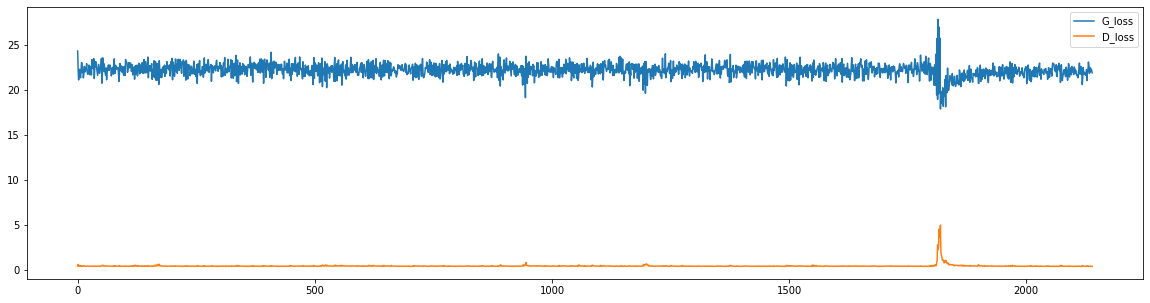

In [54]:
iters = [i for i in range(len(iters))]
part1, =  plt.plot(iters,G_losses,label = "G_loss")
part2, = plt.plot(iters,D_losses,label = "D_loss")
plt.legend()
plt.show()

In [ ]:
# param_dict = {"netD_state": netD.state_dict(),
#               "netG_state": netG.state_dict()}
# torch.save(param_dict,'/content/drive/MyDrive/Colab Notebooks/modelState/DCGAN.pth')

In [52]:
# Testing
val = next(enumerate(testloader))[1]
imgTrue = val['rImg'].numpy()
captions = val['txt']
nexam = 6
with torch.no_grad():
    noise = torch.randn((val['rImg'].size(0),100),device = device)
    noise = noise.view(noise.size(0),100,1,1).to(device)
    fake_images = netG(Variable(val['rEmbed'].float()).to(device),noise).cpu().numpy()






Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i


this flower has clusters of tiny red blooms with red rounded petals.

pedicel is greeen in color,petals are spiky and needle shaped

many stamen are ther with larger anthers trhat are white oin color

this flower has a thick green stem leading up a funnel-shaped white petal with a tall yellow pistil.

this flower has petals that are pink and has green stamen

this flower has multiple yellow blossoms with crinkled petals arranged vertically on its stem.



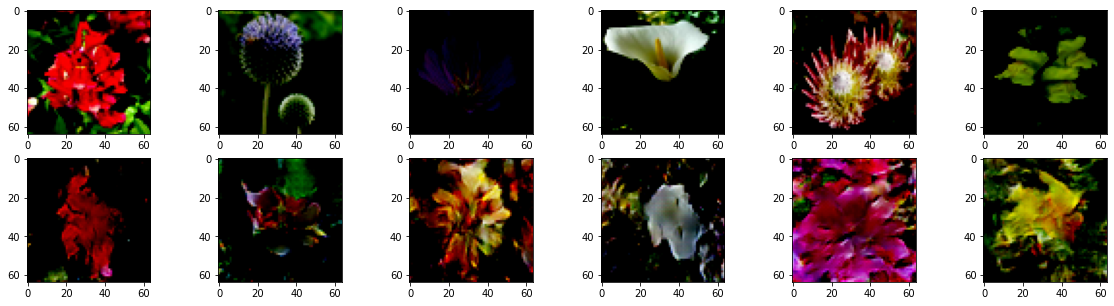

In [53]:
plt.rcParams["figure.figsize"] = (20,5)
for i in range(nexam):
    GT = imgTrue[i].transpose(1,2,0)
    Gen = fake_images[i].transpose(1,2,0)
    plt.subplot(2,nexam,i+1)
    plt.imshow(GT)
    plt.subplot(2,nexam,i+1+nexam)
    plt.imshow(Gen)
print()
for i in range(nexam):
    print(val['txt'][i])
plt.show()